- Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
- Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
- Построить случайный лес, вывести важность признаков
- Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
- Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
- Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
- В качестве решения: Jupyter notebook с кодом, комментариями и графиками, ссылка на гитхаб

In [301]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
from sklearn.model_selection import train_test_split

## Решаем задачу регрессии - предскажем цены на недвижимость

In [302]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [303]:
data['SalePrice'] = data['SalePrice'].apply(lambda x: 10 if x >= 500000 else round(x/50000))
data = data.drop(columns=['LotShape', 'Utilities', 'Condition2', 'BldgType', 'HouseStyle', 'RoofMatl', 'MasVnrType', \
'Heating', 'Electrical', 'Functional', 'GarageFinish', 'GarageQual', 'PoolQC', 'SaleType'])
y = data['SalePrice']
X = data.drop(columns=['SalePrice'])

In [304]:
#LotShape, Utilities, Condition2, BldgType, HouseStyle, RoofMatl, MasVnrType, / 
#Heating, Electrical, Functional, GarageFinish, GarageQual, PoolQC, SaleType

In [305]:
import warnings
warnings.filterwarnings("ignore")

In [306]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [307]:
d_train = X_train
d_test = X_test
dummy_y_train = pd.get_dummies(y_train)
dummy_y_test = pd.get_dummies(y_test)

In [308]:
# Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

In [309]:
# Закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')
# Отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['id','SalePrice'])]

In [310]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(X_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(X_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([X_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([X_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

## Необходимо использовать 10-fold кросс-валидацию для оценки качества моделей

In [349]:
from sklearn.model_selection import cross_val_score

for i in dummy_y_train:
    cross = cross_val_score( LogisticRegression(), X_test, dummy_y_test[i], cv = 10, scoring = 'accuracy' )
    print(cross)
    print(np.mean(cross))

[0.93333333 0.96666667 0.96551724 1.         1.         0.79310345
 0.96551724 1.         0.96551724 0.93103448]
0.9520689655172413
[0.93333333 0.8        0.89655172 0.75862069 0.79310345 0.89655172
 0.86206897 0.75862069 0.93103448 0.93103448]
0.8560919540229885
[0.83333333 0.76666667 0.6        0.75862069 0.79310345 0.65517241
 0.68965517 0.72413793 0.75862069 0.64285714]
0.722216748768473
[0.86666667 0.93333333 0.73333333 0.76666667 0.86666667 0.79310345
 0.79310345 0.82142857 0.89285714 0.78571429]
0.8252873563218392
[0.86666667 0.83333333 0.86666667 0.9        0.9        0.9
 0.89285714 0.92857143 0.96428571 0.92857143]
0.8980952380952381
[0.9        0.9        0.89655172 0.93103448 0.82758621 0.86206897
 0.89655172 0.89655172 0.86206897 0.89655172]
0.886896551724138
[0.96666667 0.83333333 0.93333333 0.96666667 0.93333333 0.93333333
 0.96428571 1.         1.         0.92857143]
0.9459523809523811
[0.96666667 0.96666667 1.         1.         0.96551724 1.
 0.96551724 1.         0.9

## Построить случайный лес, вывести важность признаков

In [316]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [317]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

def forest_to_y(X_test, X_train, y_test, y_train) :
    
    clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
    clf_tree.fit(X_train, y_train)

    bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1)
    bag_clf.fit(X_train, y_train)
    
    y_pred_test = bag_clf.predict_proba(X_test)[:, 1]
    y_pred_train = bag_clf.predict_proba(X_train)[:, 1]

    y_pred_test_rf = clf_rf.predict_proba(X_test)[:, 1]
    y_pred_train_rf = clf_rf.predict_proba(X_train)[:, 1]

    fig, ax = plt.subplots()
    print('Train RF:')
    show_auc(y_train, y_pred_train_rf, ax, 'train rf')
    print('Test RF:')
    show_auc(y_test, y_pred_test_rf, ax, 'test rf')
    print('Train:')
    show_auc(y_train, y_pred_train, ax, 'train bag')
    print('Test:')
    show_auc(y_test, y_pred_test, ax, 'test bag')
    plt.legend();

    plt.legend();

Train RF:
ROC AUC: 0.9203
Test RF:
ROC AUC: 0.9298
Train:
ROC AUC: 0.9888
Test:
ROC AUC: 0.8842
Train RF:
ROC AUC: 0.9583
Test RF:
ROC AUC: 0.9045
Train:
ROC AUC: 0.9674
Test:
ROC AUC: 0.9095
Train RF:
ROC AUC: 0.6418
Test RF:
ROC AUC: 0.6344
Train:
ROC AUC: 0.9511
Test:
ROC AUC: 0.9133
Train RF:
ROC AUC: 0.2611
Test RF:
ROC AUC: 0.2151
Train:
ROC AUC: 0.9438
Test:
ROC AUC: 0.8895
Train RF:
ROC AUC: 0.1815
Test RF:
ROC AUC: 0.1966
Train:
ROC AUC: 0.9572
Test:
ROC AUC: 0.9287
Train RF:
ROC AUC: 0.1345
Test RF:
ROC AUC: 0.1758
Train:
ROC AUC: 0.9695
Test:
ROC AUC: 0.9021
Train RF:
ROC AUC: 0.1648
Test RF:
ROC AUC: 0.1463
Train:
ROC AUC: 0.9777
Test:
ROC AUC: 0.9534
Train RF:
ROC AUC: 0.1502
Test RF:
ROC AUC: 0.1181
Train:
ROC AUC: 0.9795
Test:
ROC AUC: 0.9621
Train RF:
ROC AUC: 0.1179
Test RF:
ROC AUC: 0.0744
Train:
ROC AUC: 0.9935
Test:
ROC AUC: 0.9815
Train RF:
ROC AUC: 0.1008
Test RF:
ROC AUC: 0.0150
Train:
ROC AUC: 0.9924
Test:
ROC AUC: 0.9919


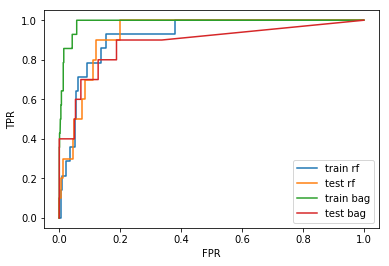

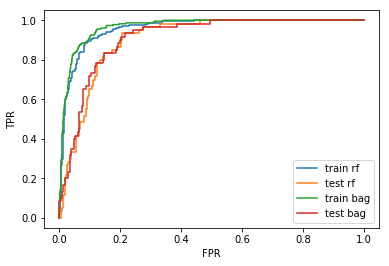

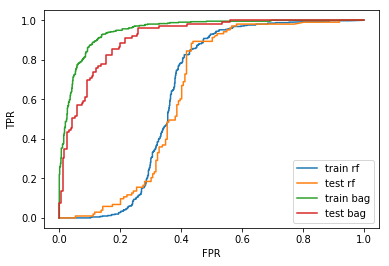

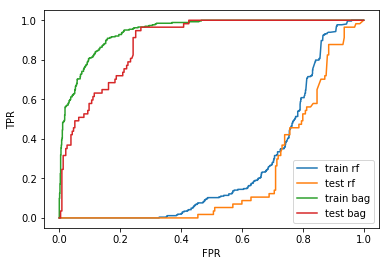

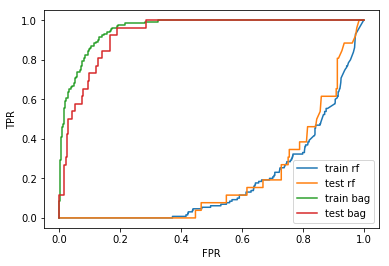

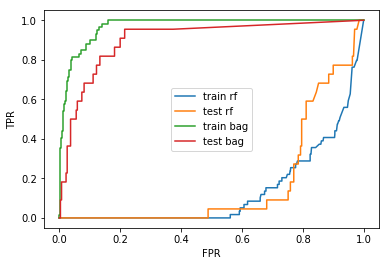

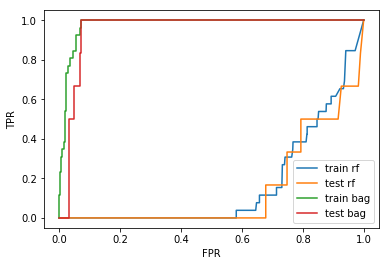

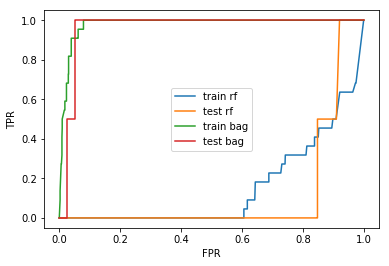

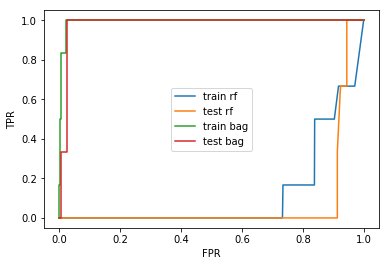

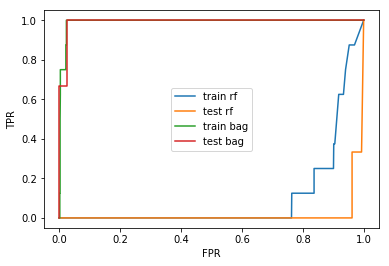

In [318]:
for i in dummy_y_train:
    if i not in dummy_y_train or i not in dummy_y_test:
        print(i)
        continue
    forest_to_y(X_test, X_train, dummy_y_test[i], dummy_y_train[i])

In [319]:
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False).head(20)

4      0.145317
19     0.128794
16     0.120297
13     0.084971
6      0.081492
12     0.066611
27     0.042175
9      0.036476
25     0.028824
3      0.025519
7      0.022843
26     0.022591
8      0.022517
29     0.022110
174    0.014852
125    0.014492
1      0.014278
14     0.014178
24     0.013608
185    0.012748
dtype: float64

## Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную

## Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии

In [340]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

def steking_func(num_feat, d_train, d_test, y_train, y_test, dummy_train, dummy_test):

    train_median = X_train[num_feat].median()

    X_train_lin = pd.concat([d_train[num_feat].fillna(train_median),
                         d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                         dummy_train], axis=1)

    X_test_lin = pd.concat([d_test[num_feat].fillna(train_median),
                         d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                         dummy_test], axis=1)

    scaler = StandardScaler()
    scaler.fit(X_train_lin[num_feat])

    X_train_lin[num_feat] = scaler.transform(X_train_lin[num_feat])
    X_test_lin[num_feat] = scaler.transform(X_test_lin[num_feat])
    
    
    clf_lr = LogisticRegression(penalty='l1', C=0.1)
    clf_lr.fit(X_train_lin, y_train)
    
    y_pred_lin_test = clf_lr.predict_proba(X_test_lin)[:, 1]
    y_pred_lin_train = clf_lr.predict_proba(X_train_lin)[:, 1]

    fig, ax = plt.subplots()
    print('Train:')
    show_auc(y_train, y_pred_lin_train, ax, 'train')
    print('Test:')
    show_auc(y_test, y_pred_lin_test, ax, 'test')
    plt.legend();
    
    
    stack_cv = StratifiedKFold(n_splits=10, random_state=555)

    meta_train = []
    meta_test = []
    col_names = []

    print('LR features...')
    meta_tr, meta_te = get_meta_features(clf_lr, X_train_lin, y_train, X_test_lin, stack_cv)

    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append('lr_pred')

    print('RF features...')
    meta_tr, meta_te = get_meta_features(clf_rf, X_train, y_train, X_test, stack_cv)

    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append('rf_pred')
    
    print('KNN features...')
    knn = KNeighborsClassifier(n_neighbors=1)
    meta_tr, meta_te = get_meta_features(knn, X_train, y_train, X_test, stack_cv)

    meta_train.append(meta_tr)
    meta_test.append(meta_te)
    col_names.append('knn_pred')
    
    ## Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
    
    X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
    X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)
    
    clf_lr_meta = LogisticRegression(penalty='l2', C=1)
    clf_lr_meta.fit(X_meta_train, y_train)
    
    y_pred_meta_test = clf_lr_meta.predict_proba(X_meta_test)[:, 1]

    fig, ax = plt.subplots()
    show_auc(y_test, y_pred_meta_test, ax, 'test')
    plt.legend();
    
    pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')

In [341]:
def show_auc(y, y_pred, ax, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        ax.plot(fpr, tpr, label=plot_label)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
    return auc_val

def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict_proba(X_train.iloc[test_ind])[:, 1]
        meta_test += clf.predict_proba(X_test)[:, 1]
    
    return meta_train, meta_test / stack_cv.n_splits

Train:
ROC AUC: 0.9552
Test:
ROC AUC: 0.9144
LR features...
RF features...
KNN features...
ROC AUC: 0.9227
Train:
ROC AUC: 0.9565
Test:
ROC AUC: 0.9279
LR features...
RF features...
KNN features...
ROC AUC: 0.9283
Train:
ROC AUC: 0.8050
Test:
ROC AUC: 0.7821
LR features...
RF features...
KNN features...
ROC AUC: 0.9024
Train:
ROC AUC: 0.8388
Test:
ROC AUC: 0.8703
LR features...
RF features...
KNN features...
ROC AUC: 0.9094
Train:
ROC AUC: 0.8706
Test:
ROC AUC: 0.8362
LR features...
RF features...
KNN features...
ROC AUC: 0.8907
Train:
ROC AUC: 0.9289
Test:
ROC AUC: 0.9276
LR features...
RF features...
KNN features...
ROC AUC: 0.9258
Train:
ROC AUC: 0.9515
Test:
ROC AUC: 0.9551
LR features...
RF features...
KNN features...
ROC AUC: 0.9499
Train:
ROC AUC: 0.9789
Test:
ROC AUC: 0.8879
LR features...
RF features...
KNN features...
ROC AUC: 0.9483
Train:
ROC AUC: 0.9802
Test:
ROC AUC: 0.9262
LR features...
RF features...
KNN features...
ROC AUC: 0.9735
Train:
ROC AUC: 0.9944
Test:
ROC AUC:

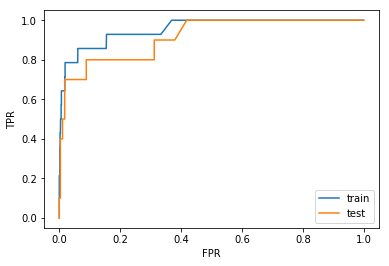

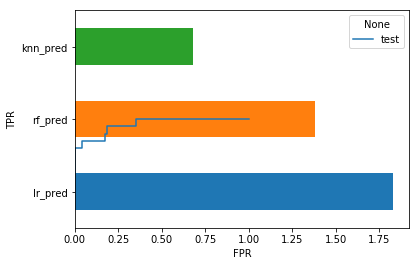

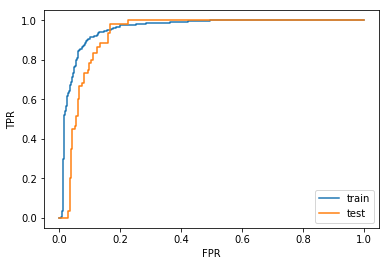

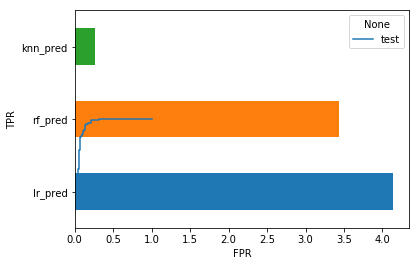

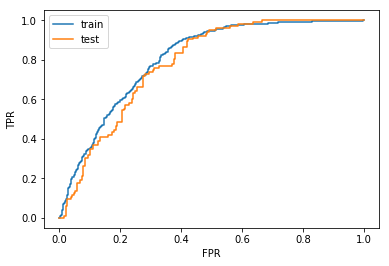

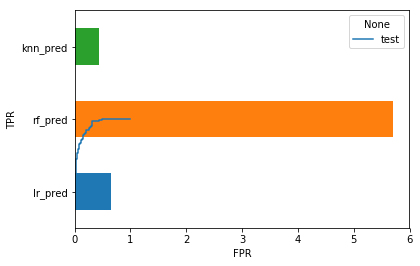

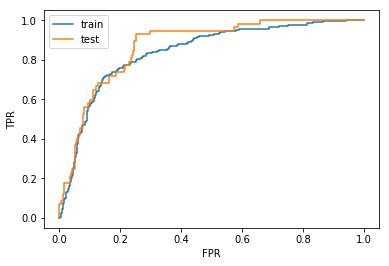

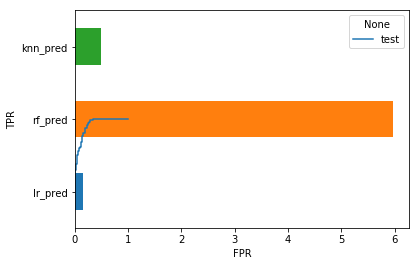

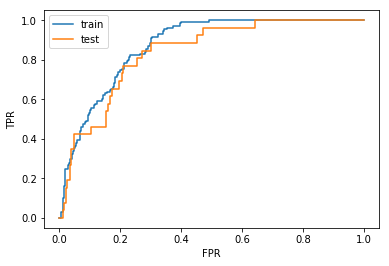

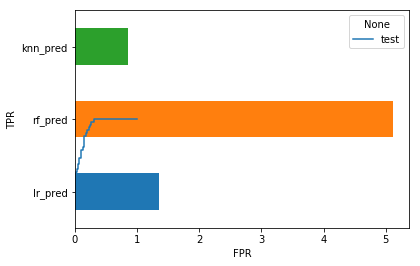

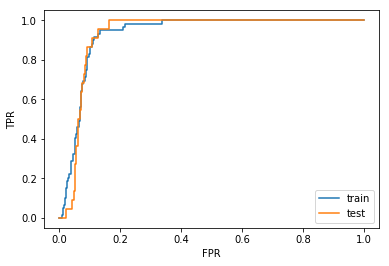

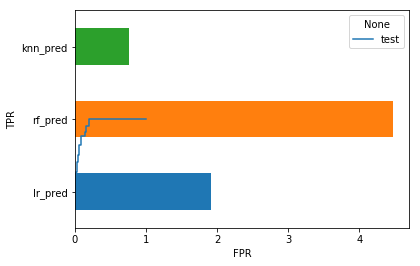

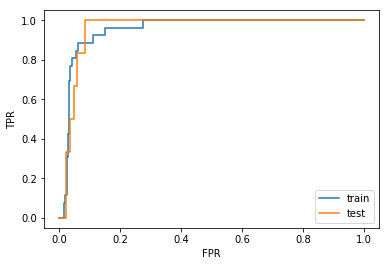

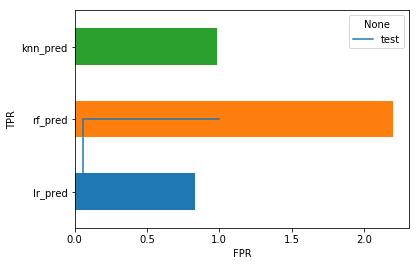

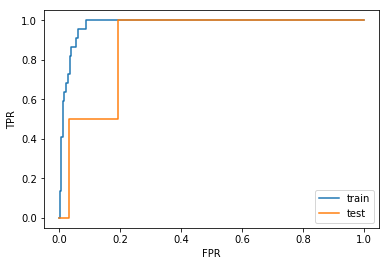

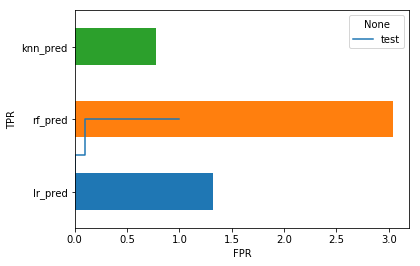

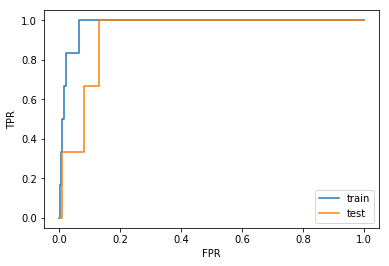

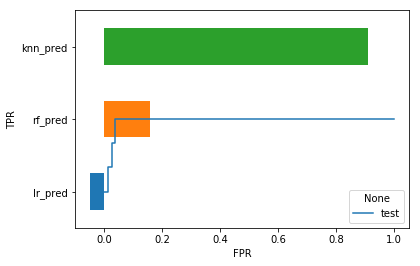

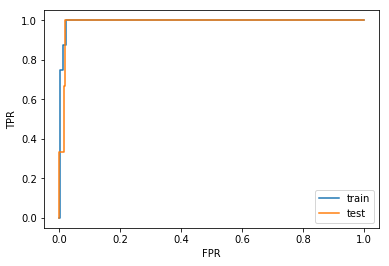

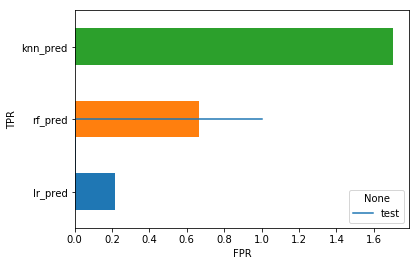

In [342]:
for i in dummy_y_train:
    if i not in dummy_y_train or i not in dummy_y_test:
        print(i)
        continue
    steking_func(num_feat, d_train, d_test, dummy_y_train[i], dummy_y_test[i], dummy_train, dummy_test)